# Финальный проект курса "Аналитика данных"
### Платформа: [SkillFactory](https://skillfactory.ru), Курс: SDA-37, Студент: Ворон Александр
-----
## На обучающей платформе запускают новую фичу - рекомендация курсов, которые могут заинтересовать при покупке интересующего курса.
### Задачи:
1. **Построить рекомендательную систему**, благодаря которой можно будет предлагать клиентам интересные им курсы. Для этого потребуется подготовить и проанализировать имеющиеся данные.
2. **Составить итоговую таблицу с рекомендациями**, снабдив её необходимыми комментариями, и представить  продакт-менеджеру.
3. **Проанализировать результаты А/Б-теста**, проведённого после внедрения фичи, сделать вывод.

In [1]:
from psycopg2 import connect
import pandas as pd
from itertools import combinations
from itertools import chain
import numpy as np

In [2]:
conn = connect(dbname='skillfactory', 
                user='skillfactory', 
                password='cCkxxLVrDE8EbvjueeMedPKt', 
                host='84.201.134.129',
                port='5432')
cursor = conn.cursor()

sql = "select user_id, resource_id from final.carts c left join final.cart_items ci on ci.cart_id = c.id where state = 'successful' and resource_type = 'Course'"
df = pd.io.sql.read_sql_query(sql, conn)

cursor.close()
conn.close()

df.head()

,user_id,resource_id
0,1010882,490
1,906674,357
2,160494,507
3,1084654,514
4,749529,489


Теперь у нас есть датафрейм с ID покупателей и ID курсов, которые они покупают.
Посмотрим, сколько у нас всего покупателей, сколько из них купили более одного курса.

In [3]:
df_unique_buyers = df.groupby('user_id').nunique().reset_index()
df_multicourse_buyers = df_unique_buyers[df_unique_buyers.resource_id>1]
print('Total buyers:',df_unique_buyers.shape[0])
print('2+ courses:',df_multicourse_buyers.shape[0])

Total buyers: 49006
2+ courses: 12656


Создаем датафрейм с унакальными ID покупателей, в чьей корзине оказалось 2 и более курсов, а также кортежи ID самих курсов.

In [4]:
df_mcid = df.drop_duplicates()
df_mcid = df_mcid.groupby('user_id').filter(lambda x: len(x) > 1).sort_values(by=['user_id','resource_id'])
df_mcid = df_mcid.groupby('user_id').agg(tuple).reset_index()
display(df_mcid.head())
print('Total buyers with 2+ courses:',df_mcid.shape[0])

,user_id,resource_id
0,51,"(516, 1099)"
1,6117,"(356, 357, 1125)"
2,10275,"(553, 1147)"
3,10457,"(361, 1138)"
4,17166,"(356, 357)"


Total buyers with 2+ courses: 12656


Посмотрим на самые популярные пары и посчитаем их общее количество

In [5]:
onehot = pd.get_dummies(df['resource_id'])\
           .set_index(df['user_id']).sum(level=0)

cnt = {}
for c in combinations(onehot, r=2):
    cnt[c] = onehot[[*c]].ge(1).all(1).sum()

df_pairs = pd.DataFrame(cnt.items(), columns=['pairs', 'users'])
df_pairs = df_pairs[df_pairs['users']>0].sort_values('users', ascending=False).reset_index(drop=True)
display(df_pairs.head())
print('Total pairs:',df_pairs.shape[0])

,pairs,users
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290


Total pairs: 3989


Также можно пойти более привычным путем - создать список всех уникальных пар, на его основе сделать датафрейм и посчитать количество пользователей с каждой парой.
```
pair_list = []
for i in df_mcid.resource_id:
    pair_list.append(list(combinations(i,2)))
pair_list = list(set(chain(*pair_list)))
print('Unique pairs:',len(pair_list))
df_pairs = pd.DataFrame({'pairs':pair_list, 'users':0})
df_pairs['users'] = df_pairs['pairs'].map(lambda x: len([y for y in df_mcid['resource_id'].values if set(x).issubset(y)])) # this line is stackoverflow help
df_pairs = df_pairs.sort_values('users', ascending=False)
display(df_pairs.head())
print('Total pairs:',df_pairs.shape[0])
```
Такой код работает немного дольше, чем использованный в решении.
___
*Used solution and the part of this one are from [StackOverflow](https://stackoverflow.com/questions/67232424/how-to-make-a-function-for-dataframe-that-checks-if-big-tuple-contains-all-the-e). Thanks to these incredible guys!*

Посмотрим, сколько всего есть курсов

In [6]:
courses = set(df.groupby('resource_id').nunique().index)
print('Total courses:',len(courses))

Total courses: 126


Внесем небольшие изменения в наш датафрейм с курсами для удобства и посмотрим, какие пары можно не рассматривать для предложений.

In [7]:
df_pairs[['1course','2course']] = pd.DataFrame(df_pairs['pairs'].tolist(), index=df_pairs.index)

In [8]:
for i in range (1,8):
    print(f"{df_pairs[df_pairs.users.isin(range(1,i+1))].shape[0]} пар выбрали {i} или менее пользователей. Среди более популярных пар {len(set(df_pairs[~df_pairs.users.isin(range(1,i+1))]['1course']) | (set(df_pairs[~df_pairs.users.isin(range(1,i+1))]['1course'])))} курсов")

1185 пар выбрали 1 или менее пользователей. Среди более популярных пар 111 курсов
1763 пар выбрали 2 или менее пользователей. Среди более популярных пар 108 курсов
2129 пар выбрали 3 или менее пользователей. Среди более популярных пар 103 курсов
2388 пар выбрали 4 или менее пользователей. Среди более популярных пар 95 курсов
2590 пар выбрали 5 или менее пользователей. Среди более популярных пар 90 курсов
2738 пар выбрали 6 или менее пользователей. Среди более популярных пар 86 курсов
2886 пар выбрали 7 или менее пользователей. Среди более популярных пар 86 курсов


Для рекомендаций нам понадобится функция, которая будет выбирать самую популярную пару, в которой есть выбранный курс, если такая пара была выбрана хотя бы 4 людьми (эту настройку можно регулировать параметром precision). В противном случае запускается рандомизатор на 30 самых популярных курсов (эту настройку можно регулировать параметром top_courses_limit). Аналогично функция работает для вторичной рекомендации, только для второй по популярности пары.
  
Таким образом мы отсекаем случайно выбранные и непопулярные курсы, когда человеку интересно попробовать себя в двух совершенно разных областях, комбинация которых может быть больше никому не интересна. Рандомизатор - не идеальное решение, но он будет предлагать более популярные курсы. Если бы были дополнительные данные о курсах по их направлениям и областям, отсечку можно увеличить, но нужно смотреть по категориям насколько. Вероятно, она будет плавающая. Впрочем, это для классифицированных курсов лучше проработать другую систему рекомендаций. Рандом по 40 самым популярным курсам, чтобы дать возможность маловостребованным курсам так же войти в подборку. Можно сделать более узкую настройку на 10 или 20 курсов. Если бы было разделение курсов по категориям, это ограничение можно было бы снять (или оставить для рекомендации более популярных курсов), и добавить рамки одного направления.  
  
Выбор пал на precision=4. Так мы отсекаем 53% пар, в остальных 47% находится 82% всех возможных курсов (103 из 126). Если поставить значение выше, то слишком много курсов не попадет в рекомендации. При низких значениях precision (отсечка непопулярных курсов), результат рандомайзера может оказаться более эффективным, чем реальный выбор людей.
top_courses_limit=40, чтобы дать возможность попасть в рекомендации не самым популярным курсам (30% выборка), но и не предлагать аутсайдеров.

### Функция для рекомендаций

In [9]:
import random

precision = 4
top_courses_limit = 40

top_courses = set(df_pairs['1course'].iloc[:top_courses_limit]) | set(df_pairs['2course'].iloc[:top_courses_limit])

def recom(chosen):
    mask = df_pairs[['1course','2course']][(df_pairs['1course'] == chosen) | (df_pairs['2course'] == chosen)]
    pair_count = df_pairs['users'][(df_pairs['1course'] == chosen) | (df_pairs['2course'] == chosen)].iloc[0]
    if pair_count > precision:
        rec1 = [x for x in mask.iloc[0] if x != chosen][0]
        rec2 = [x for x in mask.iloc[1] if x != chosen][0]
    elif pair_count == precision:
        rec1 = [x for x in mask.iloc[0] if x != chosen][0]
        rec2 = random.choice([x for x in top_courses if x not in [chosen,rec1]])
    else:
        rec1, rec2 = random.sample([x for x in top_courses if x != chosen], 2)
    return (rec1, rec2)

Альтернативный вариант, не отсекать непопулярные пары. Так в предложках появляются курсы, о которых сразу можно и не подумать, но высока вероятность рекомендации бесполезного курса. Вторая функция выдаст либо вторую по популярности пару, либо самую популярную пару на рекомендацию, если для выбранного курса существует всего одна пара.  
  
Использование try-except вместо if-else в этом случае увеличит время работы кода несущественно, но делает его заметно проще при чтении. Такая запись допустима, т.к. у нас проверяется не какое-то конкретное условие для выполнения кода, а сама возможность исполнения такого кода.  
  
Для использования этого варианта просто отключите предыдущий блок и включите следующий (не забудьте удалить кавычки в начале и в конце).

```
def recom(chosen):
    mask = df_pairs[['1course','2course']][(df_pairs['1course'] == chosen) | (df_pairs['2course'] == chosen)]
    rec1 = [x for x in mask.iloc[0] if x != chosen][0]
    try:
        rec2 = [x for x in mask.iloc[1] if x != chosen][0]
    except:
        rec2 = [x for x in mask.iloc[0] if x != chosen][0]
    return (rec1, rec2)
```

Создадим таблицу рекомендаций и проверим, есть ли в рекомендациях повторы.

In [10]:
recommend = pd.DataFrame({'course_in_the_cart':list(courses)}).sort_values('course_in_the_cart').reset_index(drop=True)
recommend['r'] = recommend.course_in_the_cart.apply(recom)
recommend[['main_r_course','sec_r_course']] = pd.DataFrame(recommend['r'].tolist(), index=recommend.index)
recommend.drop('r', axis=1, inplace=True)
recommend[(recommend.course_in_the_cart == recommend.main_r_course) | (recommend.course_in_the_cart == recommend.sec_r_course) | (recommend.main_r_course == recommend.sec_r_course)]

,course_in_the_cart,main_r_course,sec_r_course


Что ж, все в порядке. Посмотрим на нашу таблицу рекомендаций.

In [11]:
recommend

,course_in_the_cart,main_r_course,sec_r_course
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
...,...,...,...
121,1188,1141,513
122,1198,571,912
123,1199,490,502
124,1200,552,1125


Посмотрим на рекомендации для пяти самых популярных пар курсов.

In [12]:
popular = set(df.groupby('resource_id').count().sort_values('user_id', ascending=False).iloc[:5].index)
recommend[recommend.course_in_the_cart.map(lambda x: x in popular)]

,course_in_the_cart,main_r_course,sec_r_course
14,490,566,551
24,515,551,489
30,551,566,515
36,566,551,794
65,794,566,551


Похоже, эти ребята в одной банде и предлагают своих. Значит, рекомендательная система работает так, как должна - эти курсы явно взаимосвязаны, и такими тройками будут интересны нашим пользователям.

Скорее всего люди, которые будут покупать больше трех курсов, сделают осмысленный выбор, не опираясь на рекомендации. Однако, можно проанализировать корзину глубже, и для пользователей, купивших или положивших в корзину 2 или более курса, добавить рекомендации по другой логике. Например, исключить уже показанные рекомендации и продвинуться глубже по оценке популярности. Или отсортировать курсы по направлениям и давать рандомные рекомендации.

В блоке ниже в cart можно ввести любой курс из выбранных человеком и посмотреть, какие курсы предложит ему система.

In [13]:
cart = 1188
recommend[recommend['course_in_the_cart'] == cart]

,course_in_the_cart,main_r_course,sec_r_course
121,1188,1141,513


## Итак,
мы построили рекомендательную систему, которая настроена по следующим параметрам:

|Условие|Действие для первой рекомендации|Действие для второй рекомендации|
|---|---|---|
|Если в корзине курс, который попадался в паре у k или больше людей, то|предлагается самая популярная пара этого курса|предлагается вторая по популярности пара этого курса|
|Иначе|запускается рандомизатор на n самых популярных курсов|запускается рандомизатор на n самых популярных курсов|
|Значения по умолчанию|k=4, n=40||

Параметры k и n настраиваются в блоке "Функция для рекомендаций", где
            k - значение переменной precision
            n - значение переменной tpo_courses_limit

Кроме того, есть дополнительная возможность с другой рекомендательной системой:

|Условие|Действие для первой рекомендации|Действие для второй рекомендации|
|---|---|---|
|Если в корзине курс, который выбрало 2 или более людей,|предлагается самая популярная пара этого курса|предлагается вторая по популярности пара этого курса|
|Если такой курс был в паре только у одного человека,|предлагается самая популярная пара этого курса|предлагается самая популярная пара к первой рекомендации|  
  
  
Проверить, какие рекомендации дает система можно в блоке выше, подставив ID нужного курса в переменную cart  

# Тестирование новой фичи
## Проверка
Конверсия до внедрения фичи - 3.2%  
Ожидаемая конверсия после внедрения - 4%  
  
Уровень достоверности - 95% ($\alpha$ = 5%)  
Статистическая мощность - 80% ($\beta$ = 20%)  
  
Контрольная группа: 8732 клиента, из них 293 купили больше 1 курса.  
Тестовая группа: 8847 клиентов, из них 347 больше 1 курса.

In [14]:
num_a, num_b = 8732, 8847
mult_a, mult_b = 293, 347
rate_a, rate_b = mult_a / num_a, mult_b / num_b

Посмотрим, насколько изменилось количество покупателей с 2+ курсами после внедрения фичи (В)

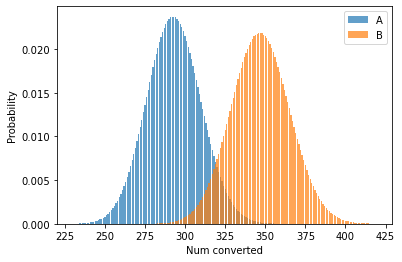

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import binom

prob_conversions = np.arange(230, 420)
prob_a = binom(num_a, rate_a).pmf(prob_conversions)
prob_b = binom(num_b, rate_b).pmf(prob_conversions)

plt.bar(prob_conversions, prob_a, label="A", alpha=0.7)
plt.bar(prob_conversions, prob_b, label="B", alpha=0.7)
plt.legend()
plt.xlabel("Num converted"); plt.ylabel("Probability");

Так же взглянем на изменение коэффициента конверсии

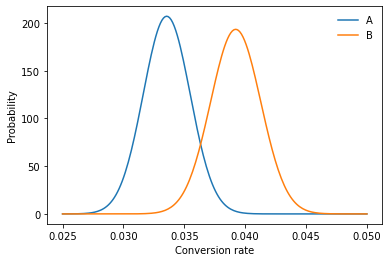

In [16]:
from scipy.stats import norm

std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

conv_rate = np.linspace(0.025, 0.05, 200)
prob_a = norm(rate_a, std_a).pdf(conv_rate)
prob_b = norm(rate_b, std_b).pdf(conv_rate)

plt.plot(conv_rate, prob_a, label="A")
plt.plot(conv_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

Немного цифр

zscore is 2.0071, p-value 0.0224


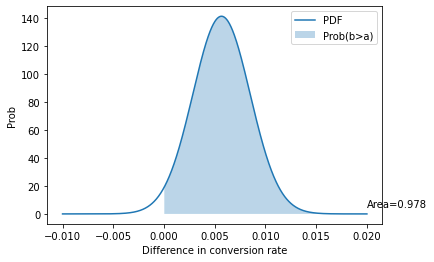

In [17]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.01, 0.02, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.4f}, p-value {norm().sf(z_score):0.4f}")

In [18]:
def get_confidence_ab_test(click_a, num_a, click_b, num_b):
    rate_a = mult_a / num_a
    rate_b = mult_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(f"Мы можем утверждать, что внедрение фичи успешно с вероятностью {get_confidence_ab_test(mult_a, num_a, mult_b, num_b):.1%}")

Мы можем утверждать, что внедрение фичи успешно с вероятностью 97.8%


# Заключение
Итак, мы можем утверждать, что введение системы рекомендаций курсов повышает конверсию и продажи с вероятностью почти 98%. Мы добились повышения конверсии до 4%, нужно реализовывать вариант с рекомендациями для все клиентов.